In [31]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Input, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.metrics import Precision, Recall

# Define dataset paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# Load image file paths
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(3000)

# Function to preprocess images with EfficientNet
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0  # Normalize between 0 and 1
    return img

# Function to preprocess twin pairs
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), tf.reshape(label, (1,)))

# Create dataset with preprocessed images
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = negatives.concatenate(positives).map(preprocess_twin).cache().shuffle(buffer_size=10000).batch(16).prefetch(8)

# Split dataset into train/test sets
train_data = data.take(round(len(data) * 0.7))
test_data = data.skip(round(len(data) * 0.7))

# Custom L1 Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Define embedding model using EfficientNet

def make_embedding():
    base_model = EfficientNetB0(include_top=False, input_shape=(100, 100, 3), weights='imagenet')
    base_model.trainable = False  # Freeze base model layers
    
    inp = Input(shape=(100, 100, 3), name='input_image')
    x = base_model(inp, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='sigmoid')(x)
    
    return Model(inputs=inp, outputs=x, name='embedding')

embedding = make_embedding()

# Define Siamese Model
def make_siamese_model(): 
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        yhat = tf.squeeze(yhat)
        loss = binary_cross_loss(y, yhat)
    print(loss)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

EPOCHS = 10
train(train_data, EPOCHS)

siamese_model.save('siamesemodelv3.h5')
siamese_model = tf.keras.models.load_model('siamesemodelv3.h5', 
                                           custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │  9,296,547 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_8 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_8[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 9,300,644 (35.48 MB)

 Trainable params: 5,251,073 (20.03 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


 Epoch 1/10
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/steps/ste
1/1 ━━━━━━━━━━━━━━━

2025-04-03 18:47:53.794343: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/steps/st
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/steps/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/steps/ste
1/1 ━━━━━━━━━━━━━━

In [33]:
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy

# Load the trained model
siamese_model = tf.keras.models.load_model('siamesemodelv3.keras', 
                                           custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

# Define accuracy metric
accuracy = BinaryAccuracy()

def test_model(test_data):
    for batch in test_data:
        X = batch[:2]  # Input image and validation image
        y_true = batch[2]  # True labels
        y_pred = siamese_model.predict(X)  # Model predictions
        accuracy.update_state(y_true, y_pred)
    
    print(f"Testing Accuracy: {accuracy.result().numpy() * 100:.2f}%")

test_model(test_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━

In [32]:
# Save the model using the new Keras format
siamese_model.save('siamesemodelv3.keras')

# Load the model with custom objects
siamese_model = tf.keras.models.load_model(
    'siamesemodelv3.keras', 
    custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy}
)

# Compile the model manually if needed
siamese_model.compile(optimizer=opt, loss=binary_cross_loss)


In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Multiply, DepthwiseConv2D, Input, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
import os
import numpy as np

# Swish Activation
def swish(x):
    return x * tf.nn.sigmoid(x)

# Squeeze and Excitation block
def se_block(inputs, se_ratio=0.25):
    filters = inputs.shape[-1]
    se_filters = max(1, int(filters * se_ratio))
    se = GlobalAveragePooling2D()(inputs)
    se = Reshape((1, 1, filters))(se)
    se = Conv2D(se_filters, 1, activation='swish')(se)
    se = Conv2D(filters, 1, activation='sigmoid')(se)
    return Multiply()([inputs, se])

# MBConv Block
def mbconv_block(inputs, in_channels, out_channels, kernel_size, stride, expand_ratio, se_ratio=0.25):
    x = inputs
    expanded = in_channels * expand_ratio
    
    if expand_ratio != 1:
        x = Conv2D(expanded, 1, padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation(swish)(x)

    x = DepthwiseConv2D(kernel_size, strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    x = se_block(x, se_ratio)

    x = Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    if stride == 1 and in_channels == out_channels:
        x = Add()([inputs, x])

    return x

# EfficientNetB0 Blocks Configuration
blocks_args = [
    (1, 16, 1, 1, 3),
    (6, 24, 2, 2, 3),
    (6, 40, 2, 2, 5),
    (6, 80, 3, 2, 3),
    (6, 112, 3, 1, 5),
    (6, 192, 4, 2, 5),
    (6, 320, 1, 1, 3),
]

# Custom EfficientNetB0 Backbone
def build_custom_efficientnet_b0(input_shape=(100, 100, 3)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(32, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    in_channels = 32
    for (expand_ratio, out_channels, repeats, stride, kernel_size) in blocks_args:
        for i in range(repeats):
            s = stride if i == 0 else 1
            x = mbconv_block(x, in_channels, out_channels, kernel_size, s, expand_ratio)
            in_channels = out_channels

    x = Conv2D(1280, 1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation(swish)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='sigmoid')(x)

    return Model(inputs, x, name="CustomEfficientNetB0")

# Custom L1 Distance Layer
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# Define embedding model using custom EfficientNetB0
def make_embedding():
    base_model = build_custom_efficientnet_b0()
    base_model.trainable = False
    
    inp = Input(shape=(100, 100, 3), name='input_image')
    x = base_model(inp, training=False)
    return Model(inputs=inp, outputs=x, name='embedding')

embedding = make_embedding()

# Siamese Model
def make_siamese_model(): 
    input_image = Input(name='input_img', shape=(100,100,3))
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    distances = L1Dist()(embedding(input_image), embedding(validation_image))
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

siamese_model = make_siamese_model()
siamese_model.summary()

# Dataset Paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# Load image file paths
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(3000)

# Preprocessing
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), tf.reshape(label, (1,)))

# Create training data
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives).map(preprocess_twin).cache().shuffle(buffer_size=10000).batch(16).prefetch(8)

train_data = data.take(round(len(data) * 0.7))
test_data = data.skip(round(len(data) * 0.7))

# Training Setup
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4)
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:     
        X = batch[:2]
        y = batch[2]
        yhat = siamese_model(X, training=True)
        yhat = tf.squeeze(yhat)
        loss = binary_cross_loss(y, yhat)
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    return loss

def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(f"Loss: {loss.numpy():.4f}, Recall: {r.result().numpy():.4f}, Precision: {p.result().numpy():.4f}")
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# Train
EPOCHS = 10
train(train_data, EPOCHS)

# Save model
siamese_model.save('siamesemodelv3.h5')
siamese_model = tf.keras.models.load_model(
    'siamesemodelv3.h5', 
    custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy}
)


Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 12,431,840 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_15 (L1Dist) │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 1)         │      4,097 │ l1_dist_15[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 12,435,937 (47.44 MB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 12,431,840 (47.42 MB)


 Epoch 1/10


KeyboardInterrupt: 

In [3]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Dense, Input, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0

# Define dataset paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

# Load image file paths
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(3000)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(3000)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(3000)

# Image preprocessing
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return img

# Preprocess anchor-positive/negative with label
def preprocess_twin(input_img, validation_img, label):
    return (preprocess(input_img), preprocess(validation_img), tf.reshape(label, (1,)))

# Create paired dataset with labels
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(3000))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(3000))))
data = negatives.concatenate(positives)
data = data.map(preprocess_twin).cache().shuffle(10000).batch(16).prefetch(8)

# Proper dataset splitting
dataset_size = tf.data.experimental.cardinality(data).numpy()
train_size = int(0.7 * dataset_size)

train_data = data.take(train_size).repeat()
test_data = data.skip(train_size)

# ArcFace Layer
class ArcFaceLayer(Layer):
    def __init__(self, num_classes=2, margin=0.5, scale=64, **kwargs):
        super(ArcFaceLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.margin = margin
        self.scale = scale

    def build(self, input_shape):
        self.W = self.add_weight(name='W',
                                 shape=(input_shape[-1], self.num_classes),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs, labels):
        x = tf.nn.l2_normalize(inputs, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        logits = tf.matmul(x, W)
        theta = tf.acos(tf.clip_by_value(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = tf.cos(theta + self.margin)
        one_hot = tf.one_hot(labels, depth=self.num_classes)
        output = one_hot * target_logits + (1 - one_hot) * logits
        return self.scale * output

# Embedding model using EfficientNetB0
def make_embedding():
    base_model = EfficientNetB0(include_top=False, input_shape=(100, 100, 3), weights='imagenet')
    base_model.trainable = False
    inp = Input(shape=(100, 100, 3))
    x = base_model(inp, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512)(x)
    return Model(inp, x, name='embedding')

embedding_model = make_embedding()

# Full ArcFace Model
def make_arcface_model():
    input_img = Input(shape=(100, 100, 3), name='input_image')
    label = Input(shape=(), dtype=tf.int32, name='label')
    embeddings = embedding_model(input_img)
    logits = ArcFaceLayer()(embeddings, label)
    return Model(inputs=[input_img, label], outputs=logits, name='ArcFaceModel')

arcface_model = make_arcface_model()
arcface_model.summary()

# Loss and optimizer
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
opt = tf.keras.optimizers.Adam(1e-4)

# Training step function
@tf.function
def train_step_arcface(images, labels):
    with tf.GradientTape() as tape:
        logits = arcface_model([images, labels], training=True)
        loss = loss_fn(labels, logits)
    gradients = tape.gradient(loss, arcface_model.trainable_variables)
    opt.apply_gradients(zip(gradients, arcface_model.trainable_variables))
    return loss

# Training loop
def arcface_train(dataset, EPOCHS, steps_per_epoch):
    for epoch in range(EPOCHS):
        print(f'\nEpoch {epoch + 1}/{EPOCHS}')
        progbar = tf.keras.utils.Progbar(steps_per_epoch)
        iter_dataset = iter(dataset)
        for step in range(steps_per_epoch):
            batch = next(iter_dataset)
            img1, img2, label = batch
            loss = train_step_arcface(img1, tf.cast(label, tf.int32))
            progbar.update(step + 1)
        print(f"Loss: {loss.numpy():.4f}")

# Training execution
EPOCHS = 10
arcface_train(train_data, EPOCHS=EPOCHS, steps_per_epoch=train_size)

# Save the model
arcface_model.save('arcface_siamese_model.keras')


Model: "ArcFaceModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 512)       │  4,705,443 │ input_image[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label (InputLayer)  │ (None)            │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arc_face_layer_2    │ (None, 2)         │      1,024 │ embedding[0][0],  │
│ (ArcFaceLayer)      │                   │            │ label[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,706,467 (17.95 MB)

 Trainable params: 656,896 (2.51 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


Epoch 1/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step
Loss: 8.1999

Epoch 2/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step
Loss: 0.4205

Epoch 3/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step
Loss: 0.0824

Epoch 4/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 52ms/step
Loss: 0.0413

Epoch 5/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step
Loss: 0.0265

Epoch 6/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 54ms/step
Loss: 0.0173

Epoch 7/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step
Loss: 0.0131

Epoch 8/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step
Loss: 0.0099

Epoch 9/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step
Loss: 0.0081

Epoch 10/10
262/262 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step
Loss: 0.0061


In [6]:
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# Load model with ArcFaceLayer
arcface_model = tf.keras.models.load_model(
    'arcface_siamese_model.keras',
    custom_objects={'ArcFaceLayer': ArcFaceLayer}
)

# Accuracy metric
accuracy = SparseCategoricalAccuracy()

def test_model(test_data):
    for batch in test_data:
        # We will just use the anchor image for classification testing
        anchor_img = batch[0]
        label = tf.cast(tf.squeeze(batch[2]), tf.int32)

        # Predict logits
        logits = arcface_model.predict([anchor_img, label])
        predictions = tf.argmax(logits, axis=1)

        # Update accuracy metric
        accuracy.update_state(label, logits)
    
    print(f"Testing Accuracy: {accuracy.result().numpy() * 100:.2f}%")

test_model(test_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

Full model loaded.
Embedding model extracted.


Similarity: 1.0000 — MATCH


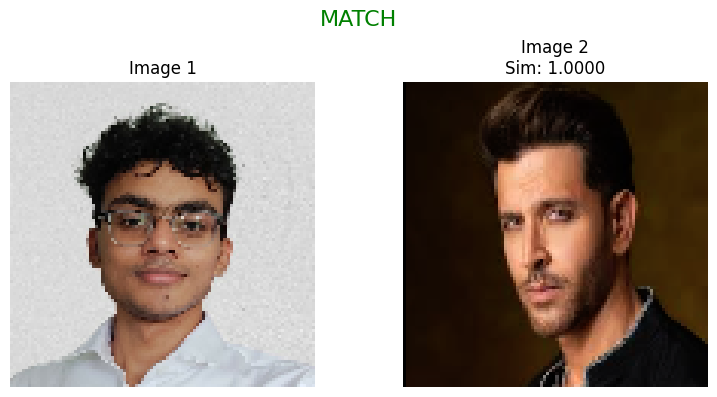

In [39]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model, Model
from keras import layers

# Your custom ArcFace layer
class ArcFaceLayer(tf.keras.layers.Layer):
    def __init__(self, n_classes=2, s=30.0, m=0.50, **kwargs):
        super().__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m

    def build(self, input_shape):
        embedding_dim = input_shape[0][-1]
        self.W = self.add_weight(name='W',
                                 shape=(embedding_dim, self.n_classes),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        x, y = inputs
        x = tf.nn.l2_normalize(x, axis=1)
        W = tf.nn.l2_normalize(self.W, axis=0)
        logits = tf.matmul(x, W)
        theta = tf.acos(tf.clip_by_value(logits, -1.0 + 1e-7, 1.0 - 1e-7))
        target_logits = tf.cos(theta + self.m)
        onehot = tf.one_hot(tf.cast(y, tf.int32), depth=self.n_classes)
        logits = logits * (1 - onehot) + target_logits * onehot
        logits *= self.s
        return logits

# Load full model
full_model = load_model("arcface_siamese_model.keras", custom_objects={"ArcFaceLayer": ArcFaceLayer})
print("Full model loaded.")

# --- Extract embedding submodel properly ---

# Step 1: Traverse the model graph to find correct input/output tensors
embedding_layer = full_model.get_layer("embedding")
embedding_tensor = embedding_layer.output

# Find the image input by checking the inputs to the embedding layer
image_input_tensor = embedding_layer.input

# Step 2: Build new model from image input to embedding output
embedding_model = Model(inputs=image_input_tensor, outputs=embedding_tensor)
print("Embedding model extracted.")

# Preprocessing
def preprocess_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.resize(img, (100, 100))
    img = img / 255.0
    return tf.expand_dims(img, axis=0)

# Compare function
def compare_images(img_path1, img_path2, threshold=0.2):
    img1 = preprocess_image(img_path1)
    img2 = preprocess_image(img_path2)

    emb1 = embedding_model.predict(img1, verbose=0)[0]
    emb2 = embedding_model.predict(img2, verbose=0)[0]

    sim = cosine_similarity([emb1], [emb2])[0][0]
    is_same = sim > threshold

    print(f"Similarity: {sim:.4f} — {'MATCH' if is_same else 'NO MATCH'}")

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(tf.squeeze(img1))
    plt.title("Image 1")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(tf.squeeze(img2))
    plt.title(f"Image 2\nSim: {sim:.4f}")
    plt.axis("off")

    plt.suptitle("MATCH" if is_same else "NO MATCH", fontsize=16, color='green' if is_same else 'red')
    plt.tight_layout()
    plt.show()

# --- Use your paths ---
REF_IMAGE = "/Users/gk/Desktop/me2.jpg"
VER_IMAGE = "/Users/gk/Desktop/qqq.png"

compare_images(REF_IMAGE, VER_IMAGE)


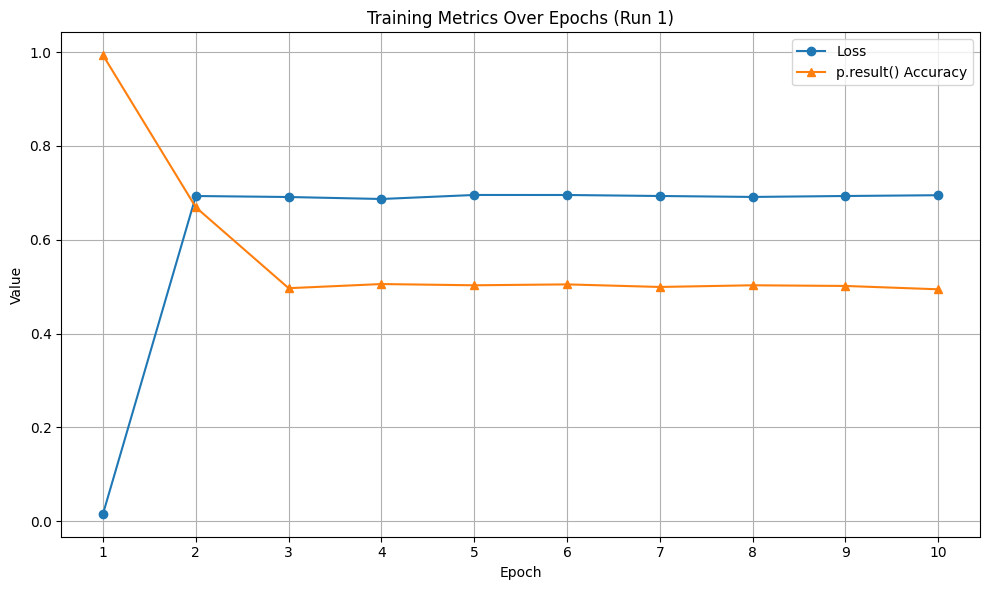

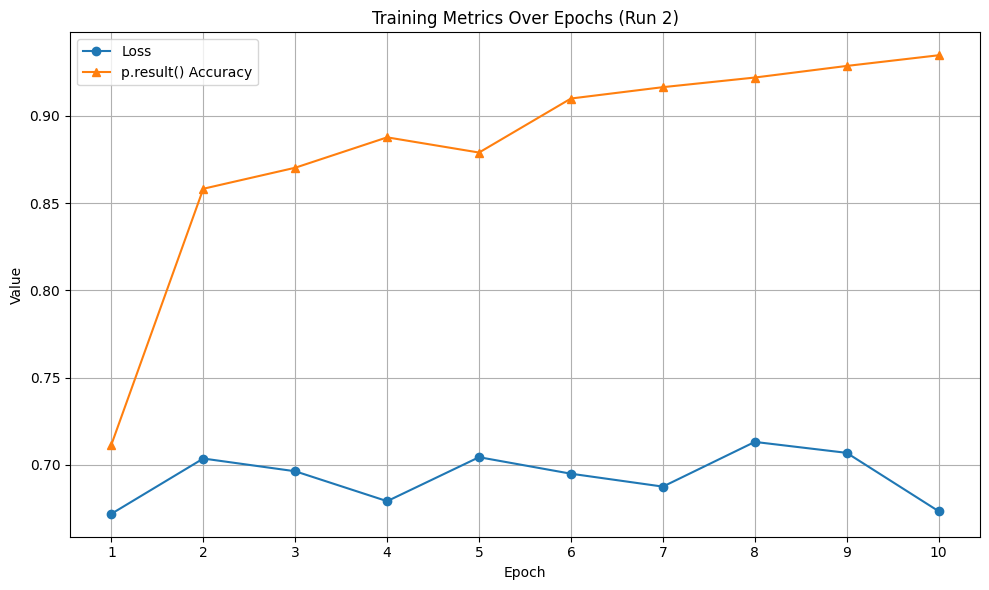

In [1]:
import matplotlib.pyplot as plt

# --- Run 1 Data ---
epochs1 = list(range(1, 11))
loss1 = [0.015771935, 0.69313353, 0.69103265, 0.68679357, 0.69536334,
         0.6953161, 0.6931802, 0.69117457, 0.69317883, 0.6948347]
p_acc1 = [0.9931615, 0.669053, 0.49666667, 0.5054762, 0.50285715,
          0.50476193, 0.49928573, 0.50285715, 0.50142854, 0.4942857]

# --- Run 2 Data ---
epochs2 = list(range(1, 11))
loss2 = [0.67199934, 0.7036693, 0.69637007, 0.67923, 0.70443916,
         0.6949675, 0.687576, 0.7131945, 0.70692, 0.6734824]
p_acc2 = [0.7116221, 0.8582677, 0.870317, 0.88772845, 0.87901604,
          0.9099804, 0.9164867, 0.9220038, 0.92865044, 0.93476844]

# --- Plot Run 1 ---
plt.figure(figsize=(10, 6))
plt.plot(epochs1, loss1, label='Loss', marker='o')
plt.plot(epochs1, p_acc1, label='p.result() Accuracy', marker='^')

plt.title('Training Metrics Over Epochs (Run 1)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(epochs1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("training_metrics_run1.png", dpi=300)
plt.show()

# --- Plot Run 2 ---
plt.figure(figsize=(10, 6))
plt.plot(epochs2, loss2, label='Loss', marker='o')
plt.plot(epochs2, p_acc2, label='p.result() Accuracy', marker='^')

plt.title('Training Metrics Over Epochs (Run 2)')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.xticks(epochs2)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("training_metrics_run2.png", dpi=300)
plt.show()
